# Personality sprint individual project template

### Table of Contents
1. [Import libraries](#imports)
1. [Import, inspect and clean training data](#inspect)
1. [Natural Language Processing](#NLP)
1. [Build classification models](#build)
1. [Model validation and evaluation](#valid)
1. [Predict test data labels from winning model](#predict)
1. [List how you've gone above and beyond the minimum](#other)


<a id='imports'></a>

## Import libraries

In [297]:
import pandas            as pd
import numpy             as np
import matplotlib.pyplot as plt
import seaborn           as sns
%matplotlib inline

#models
from sklearn.svm                      import SVC
from sklearn.naive_bayes              import GaussianNB
from sklearn.ensemble                 import RandomForestClassifier, AdaBoostClassifier
from sklearn.linear_model             import SGDClassifier
from sklearn.linear_model             import LogisticRegression
from sklearn.neighbors                import KNeighborsClassifier
from sklearn.discriminant_analysis    import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis    import QuadraticDiscriminantAnalysis
from sklearn.gaussian_process         import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.neural_network           import MLPClassifier
from sklearn.linear_model             import SGDClassifier
from sklearn.ensemble                 import GradientBoostingClassifier

#NLP
import re
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer

# validation
from sklearn.model_selection import train_test_split
from sklearn.metrics         import classification_report, confusion_matrix
from sklearn                 import metrics
from sklearn.model_selection import GridSearchCV


<a id='inspect'> </a>

## Import, inspect and clean training data

In [19]:
mbti = pd.read_csv('data/train.csv')

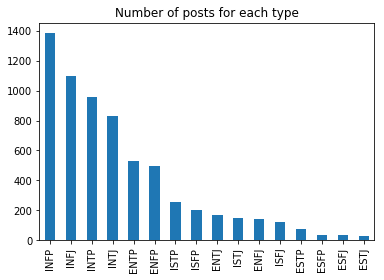

In [131]:
mbti['type'].value_counts().plot(kind = 'bar', title='Number of posts for each type')
plt.show()

In [21]:
# to increase the number of posts per type, split on the '|||' which designate a new post
all_mbti = []
for i, row in mbti.iterrows():
    for post in row['posts'].split('|||'):
        all_mbti.append([row['type'], post])
all_mbti = pd.DataFrame(all_mbti, columns=['type', 'post'])

In [22]:
print(f"before:  {mbti.shape} \nafter: {all_mbti.shape}")

before:  (6506, 2) 
after: (316548, 2)


In [23]:
mbti_type = pd.concat([mbti['type'].value_counts().to_frame(name='before'), all_mbti['type'].value_counts().to_frame(name='after')],axis=1)
mbti_type

,before,after
ENFJ,143,6947
ENFP,496,23925
ENTJ,167,8174
ENTP,530,26017
ESFJ,35,1668
ESFP,36,1663
ESTJ,30,1495
ESTP,71,3437
INFJ,1100,53807
INFP,1386,67846


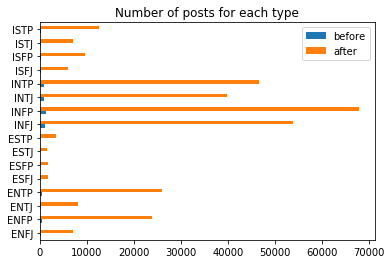

In [132]:
mbti_type.plot(kind='barh', title='Number of posts for each type')
plt.show()

In [25]:
def split_type(row):
    
    ''' Split MBTI type into individual features for Binary Classification
        eg ENFP = [0 1 0 0]
    '''
    t = row['type']
    I,N,T,J = 0,0,0,0
    
    I = 1 if t[0] =='I' else 0
    N = 1 if t[1] == 'N' else 0
    T = 1 if t[2] == 'T' else 0
    J = 1 if t[3] == 'J' else 0
    
    return pd.Series( {'IE':I, 'NS':N , 'TF': T, 'JP': J }) 

In [26]:
all_mbti = all_mbti.join(all_mbti.apply(lambda row: split_type(row), axis=1))

,type,post,IE,JP,NS,TF
0,INFJ,'http://www.youtube.com/watch?v=qsXHcwe3krw,1,1,1,0
1,INFJ,http://41.media.tumblr.com/tumblr_lfouy03PMA1q...,1,1,1,0
2,INFJ,enfp and intj moments https://www.youtube.com...,1,1,1,0
3,INFJ,What has been the most life-changing experienc...,1,1,1,0
4,INFJ,http://www.youtube.com/watch?v=vXZeYwwRDw8 h...,1,1,1,0


In [27]:
# rearrange columns
all_mbti = all_mbti[['type', 'IE', 'NS', 'TF', 'JP', 'post']]
all_mbti.head(5)

,type,IE,NS,TF,JP,post
0,INFJ,1,1,0,1,'http://www.youtube.com/watch?v=qsXHcwe3krw
1,INFJ,1,1,0,1,http://41.media.tumblr.com/tumblr_lfouy03PMA1q...
2,INFJ,1,1,0,1,enfp and intj moments https://www.youtube.com...
3,INFJ,1,1,0,1,What has been the most life-changing experienc...
4,INFJ,1,1,0,1,http://www.youtube.com/watch?v=vXZeYwwRDw8 h...


In [17]:
#all_mbti.to_csv('data/all_mbti_split.csv')
all_mbti = pd.read_csv('data/all_mbti_split.csv').drop('Unnamed: 0',axis=1)
all_mbti.head()

,type,IE,NS,TF,JP,post
0,INFJ,1,1,0,1,'http://www.youtube.com/watch?v=qsXHcwe3krw
1,INFJ,1,1,0,1,http://41.media.tumblr.com/tumblr_lfouy03PMA1q...
2,INFJ,1,1,0,1,enfp and intj moments https://www.youtube.com...
3,INFJ,1,1,0,1,What has been the most life-changing experienc...
4,INFJ,1,1,0,1,http://www.youtube.com/watch?v=vXZeYwwRDw8 h...


In [176]:
I = (all_mbti['IE'].value_counts()[1] / (all_mbti['IE'].value_counts()[1] + all_mbti['IE'].value_counts()[0])*100)
E = (all_mbti['IE'].value_counts()[0] / (all_mbti['IE'].value_counts()[1] + all_mbti['IE'].value_counts()[0])*100)
N = (all_mbti['NS'].value_counts()[1] / (all_mbti['NS'].value_counts()[1] + all_mbti['NS'].value_counts()[0])*100)
S = (all_mbti['NS'].value_counts()[0] / (all_mbti['NS'].value_counts()[1] + all_mbti['NS'].value_counts()[0])*100)
T = (all_mbti['TF'].value_counts()[1] / (all_mbti['TF'].value_counts()[1] + all_mbti['TF'].value_counts()[0])*100)
F = (all_mbti['TF'].value_counts()[0] / (all_mbti['TF'].value_counts()[1] + all_mbti['TF'].value_counts()[0])*100)
J = (all_mbti['JP'].value_counts()[1] / (all_mbti['JP'].value_counts()[1] + all_mbti['JP'].value_counts()[0])*100)
P = (all_mbti['JP'].value_counts()[0] / (all_mbti['JP'].value_counts()[1] + all_mbti['JP'].value_counts()[0])*100)
                                        
print ("Introversion (I)     -     Extroversion (E):\t")
print(f" {all_mbti['IE'].value_counts()[1]} | {I:.4}%     -      {E:.4}% |  {all_mbti['IE'].value_counts()[0]}")
print ("\nIntuition (N)        -     Sensing (S):\t\t")
print(f" {all_mbti['NS'].value_counts()[1]} | {N:.4}%     -      {S:.4}% |  {all_mbti['NS'].value_counts()[0]}")
print ("\nThinking (T)         -     Feeling (F):\t\t")
print(f" {all_mbti['TF'].value_counts()[1]} | {T:.4}%     -      {F:.4}% |   {all_mbti['TF'].value_counts()[0]}")
print ("\nJudging (J)          -     Perceiving (P):\t\t")
print(f" {all_mbti['JP'].value_counts()[1]} | {J:.4}%     -      {P:.4}% |   {all_mbti['JP'].value_counts()[0]}")

Introversion (I)     -     Extroversion (E):	
 243222 | 76.84%     -      23.16% |  73326

Intuition (N)        -     Sensing (S):		
 273129 | 86.28%     -      13.72% |  43419

Thinking (T)         -     Feeling (F):		
 145120 | 45.84%     -      54.16% |   171428

Judging (J)          -     Perceiving (P):		
 124936 | 39.47%     -      60.53% |   191612


<a id='NLP'></a>

## Natural Language Processing

In [3]:
# create structured data from unstructured text

In [33]:
# remove web URLs
pattern_url = r'http[s]?://(?:[A-Za-z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9A-Fa-f][0-9A-Fa-f]))+'
subs_url = r'url-web'
all_mbti['post'] = all_mbti['post'].replace(to_replace = pattern_url, value = subs_url, regex = True)

In [34]:
# remove emojis
pattern_url = r"(:[a-z]*:)|([:;][()pdo03])"
subs_url = r'emoji'
all_mbti['post'] = all_mbti['post'].replace(to_replace = pattern_url, value = subs_url, regex = True)

In [35]:
all_mbti['post'] = all_mbti['post'].str.replace('[^\w\s]', '') # remove punctuation 

In [36]:
all_mbti['post'] = all_mbti['post'].str.replace(r'(\b\w{1,2}\b)', '') # remove words less than 3 letters

In [37]:
all_mbti['post'] = all_mbti['post'].str.replace('\d+', '') # remove digits

In [178]:
all_mbti['post'].head()

0                                                urlweb
1                                                urlweb
2     enfp and intj moments  urlweb  sportscenter no...
3     What has been the most lifechanging experience...
4              urlweb   urlweb   repeat for most  today
5                   May the PerC Experience immerse you
6     The last thing  INFJ friend posted  his facebo...
7     Hello ENFJ Sorry  hear  your distress Its only...
8                                       urlweb  urlweb 
9                                     Welcome and stuff
10                               urlweb  Game Set Match
11    Prozac wellbrutin  least thirty minutes  movin...
12    Basically come  with three items youve determi...
13    All things  moderation  Sims  indeed  video ga...
14    Dear ENFP  What were your favorite video games...
15                                               urlweb
16                             appears   too late emoji
17                Theres someone out there for e

<a id='build'></a>

## Build classification models

In [4]:
# which algorithms will you use?

In [ ]:
names = ['Logistic Regression', 
         'Nearest Neighbors', 
         'Linear SVM', 
         'RBF SVM', 
         'Naive Bayes', 
         'LDA', 
         "QDA",          
         "Decision Tree", 
         "Random Forest",  
         "AdaBoost", 
         "Neural Net",
         'hingeSGDC', 
         'logSGDC']

In [ ]:
classifiers = [
    LogisticRegression(), 
    KNeighborsClassifier(3),
    SVC(kernel="linear", C=0.025),
    SVC(gamma=2, C=1),    
    GaussianNB(),    
    LinearDiscriminantAnalysis(),
    QuadraticDiscriminantAnalysis(),    
    
    DecisionTreeClassifier(max_depth=5),
    RandomForestClassifier(max_depth=5, n_estimators=10, max_features=1),    
    AdaBoostClassifier(),
    
    MLPClassifier(alpha=1),
    
    SGDClassifier(class_weight='balanced'),    
    SGDClassifier(loss='log', class_weight='balanced')
]

In [ ]:
results = []

models = {}
confusion = {}
class_report = {}


for name, clf in zip(names, classifiers):    
    print ('Fitting {:s} model...'.format(name))
    run_time = %time -q -o clf.fit(X_train, y_train)
    
    print ('... predicting')
    y_pred = clf.predict(X_train)   
    y_pred_test = clf.predict(X_test)
    
    print ('... scoring')
    accuracy  = metrics.accuracy_score(y_test, y_pred)
    precision = metrics.precision_score(y_test, y_pred)
    recall    = metrics.recall_score(y_test, y_pred)
    
    f1        = metrics.f1_score(y_train, y_pred)    
    f1_test   = metrics.f1_score(y_test, y_pred_test)    
    
    # save the results to dictionaries
    models[name] = clf    
    confusion[name] = metrics.confusion_matrix(y_train, y_pred)
    class_report[name] = metrics.classification_report(y_train, y_pred)
    
    results.append([name, accuracy, precision, recall, f1, f1_test, run_time.best])

    
results = pd.DataFrame(results, columns=['Classifier', 'Accuracy', 'Precision', 'Recall', 'F1 Train', 'F1 Test', 'Train Time'])
results.set_index('Classifier', inplace= True)

In [ ]:
results.sort_values('F1 Test', ascending=False)

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
results.sort_values('F1 Train', ascending=False, inplace=True)
results.plot(y=['F1 Test'], kind='bar', ax=ax[0], xlim=[0,1.1])
results.plot(y='Train Time', kind='bar', ax=ax[1])

---

In [285]:
vect = TfidfVectorizer(min_df=3, ngram_range=(1,2), stop_words='english')
X = vect.fit_transform(all_mbti['post'])

In [291]:
y = all_mbti['IE']

In [286]:

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y)

In [287]:
forest = RandomForestClassifier(n_estimators=50, random_state=2, class_weight='balanced')

In [288]:
forest.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=None, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=50, n_jobs=1, oob_score=False, random_state=2,
            verbose=0, warm_start=False)

In [289]:
forest.score(X_train, y_train)

0.97171150452169441

In [290]:
forest.score(X_test, y_test)

0.61105424769703176

In [284]:
y_pred = forest.predict(X_test)
confusion_matrix(y_pred, y_test)

array([[13897, 10712],
       [28960, 25568]])

In [204]:
print(classification_report(y_pred, y_test))

             precision    recall  f1-score   support

          0       0.69      0.60      0.64     49158
          1       0.46      0.56      0.50     29979

avg / total       0.60      0.58      0.59     79137



In [274]:
labelsIE = pd.DataFrame({'E/I':y_pred})

In [275]:
labelsIE.head()

,E/I
0,0
1,0
2,1
3,0
4,1


In [277]:
labelsIE.replace({0:'E',1:'I'}).head()

,E/I
0,E
1,E
2,I
3,E
4,I


In [294]:
from sklearn.model_selection import GridSearchCV

In [59]:
from sklearn.ensemble import AdaBoostClassifier

In [57]:
# Adaboost classifier using SAMME.R
bdt_real = AdaBoostClassifier(
    #    SVC(C=44, kernel='linear', probability=True),
     RandomForestClassifier(),
   # DecisionTreeClassifier(max_depth=2),
   # n_estimators=num_estimators,
    learning_rate=1)

In [58]:
# Adaboost classifier using SAMME
bdt_discrete = AdaBoostClassifier(
   # DecisionTreeClassifier(max_depth=2),
    RandomForestClassifier(),
   #SVC(C=44, kernel='linear', probability=True),
  #  n_estimators=num_estimators,
    learning_rate=1,
    algorithm="SAMME")

In [ ]:
# Find best value of n_estimator using grid search
param_grid = {"n_estimators" : [1, 10, 50, 100]}  #, 200, 300, 400, 500, 600]}

grid_search = GridSearchCV(bdt_real, param_grid=param_grid, cv=3, n_jobs=-1)
grid_search.fit(X_train, y_train)
print('Best parameters of Adaboost SAMME.R:' , grid_search.best_params_)
print('Best scrore of Adaboost SAMME.R:', grid_search.best_score_)

In [ ]:
%%time
grid_search = GridSearchCV(bdt_discrete, param_grid=param_grid, cv=3, n_jobs=-1)
grid_search.fit(X_train, y_train)
print 'Best parameters of Adaboost SAMME:' , grid_search.best_params_
print 'Best scrore of Adaboost SAMME:', grid_search.best_score_

<a id='valid'></a>

## Model validation and evaluation

In [5]:
# make sure your models are robust, and pick the best one

In [ ]:
from sklearn.model_selection import cross_val_score

In [ ]:
cv = []
for name, model in models.items():
    print(name)
    scores = cross_val_score(model, X=X[:n].toarray(), y=y[:n], cv=10)
    print("Accuracy: {:0.2f} (+/- {:0.2f})".format(scores.mean(), scores.std()))
    cv.append([name, scores.mean(), scores.std() ])
    
cv = pd.DataFrame(cv, columns=['Model', 'CV_Mean', 'CV_Std_Dev'])
cv.set_index('Model', inplace=True)

In [ ]:
cv.plot(y='CV_Mean', yerr='CV_Std_Dev',kind='bar', ylim=[0, 1])

## Import test data

In [6]:
# pd.read_csv...

<a id='predict'> </a>

## Predict test data labels from winning model

In [8]:
# .predict
# export as CSV in prescribed format

<a id='other'> </a>

## List how you've gone above and beyond the minimum

List:

* additional pre-processing you've done or NLP techniques you've applied
* classification algorithms you've applied, beyond those covered in this sprint (logistic regression, KNN, LDA, QDA, SVM)
* model validation you're performed
* any other creative problem-solving you've done

#### Choice of Models
decision trees often perform well on imbalanced datasets. <br>
The splitting rules that look at the class variable used in the creation of the trees, 
can force both classes to be addressed.

Due to limited processing power and time I focused on tree based algorythms, RandomForest and adaBoost using RandomForest

#### Model Validation
I tried using RandomSearch (for hints on values to start w.r.t. optimizing hyperparameters) but it took too long to run.<br>
I used GridSearchCV on Kaggle kernels for hyperparameter tuning.


#### Extra Classification Algorithm's applied,
- SGDClassifier
- - loss = 'log' similar to logistic regression
- - loss = 'hinge' similar to linearSVC
- MultinomialNB
- AdaBoost with RandomForrestClassifier()

#### Downsample Majority Class To Match Minority Class

``` python
# after y = all_mbti['IE']
# Indicies of each class' observations
i_class0 = np.where(y == 0)[0]
i_class1 = np.where(y == 1)[0]

# Number of observations in each class
n_class0 = len(i_class0)
n_class1 = len(i_class1)

# For every observation of class 0, randomly sample from class 1 without replacement
i_class1_downsampled = np.random.choice(i_class1, size=n_class0, replace=False)

# Join together class 0's target vector with the downsampled class 1's target vector
np.hstack((y[i_class0], y[i_class1_downsampled]))
```

#### Additional pre-Processing

1. Count/Tfidfvectorizer doesn't include stemming or lemmatization.<br>
I found a way to include a lemmatizer in a vectorizer (token=LemmaTokenizer())<br>
Unfortunately it was not used as it increases running time dramatically with little improvement to the metric.
``` python
   class LemmaTokenizer(object):
    def __init__(self):
        self.wnl = WordNetLemmatizer()
    def __call__(self, articles):
        return [self.wnl.lemmatize(t) for t in word_tokenize(articles)]
```  

2. I created pipelines that used the same classifier, but different [transformations](#baseline) to the data.

3. I created my own lists [stop words](#stop), neither improved from the default (using GridSearch)


#### Other Creative Problem-Solving

1. I found a function that combines countvectorize and tf-idf; Tfidfvectorizer. easier to do gridsearch and less chance of error, also reducing redundant code.

2. Using RegEx I created extra features by counting the number of question marks, exclamation marks, pictures, <br>youtube links, elipses, emojis, words in all caps, and words bigger than 5 letters.

3. I created pipelines to select numerical features columns and apply MinMaxScaler, another to countvectorize the text feature. <br>The main pipeline that used FeatureUnion to combine the resuts of previous pipelines and feed to the classifier ([code below](#FUnion))

4. I saved the models by "pickling" them, so as to save time on retraining using `joblib`
``` python
# save the model to disk
filename = 'finalized_model.sav'
joblib.dump(model, filename)
# load the model from disk
loaded_model = joblib.load(filename)
```

---
### Code snippets

<a id='stop'> </a>
#### Stopwords

``` python
my_stopwords = ['a', 'about', 'above', 'after', 'again', 'against', 'ain', 'all', 'am', 'an', 'and', 'any', 'are', 'aren',
                "aren't", 'as', 'at', 'be', 'because', 'been', 'before', 'being', 'below', 'between', 'both', 'but', 'by', 'can',
                'couldn', "couldn't", 'd', 'did', 'didn', "didn't", 'do', 'does', 'doesn', "doesn't", 'doing', 'don', "don't",
                'down', 'during', 'each', 'few', 'for', 'from', 'further', 'had', 'hadn', "hadn't", 'has', 'hasn', "hasn't", 'ESTJ',
                'have', 'haven', "haven't", 'having',  'how', 'if', 'in', 'into', 'is', 'isn', "isn't", 'it', "it's", 'its', 'then',
                'itself', 'just', 'll', 'm', 'ma', 'me', 'mightn', "mightn't", 'more', 'most', 'mustn', "mustn't", 'needn', "shan't",
                "needn't", 'now', 'o', 'of', 'off', 'on', 'once', 'only', 'or', 'other', 'out', 'over', 'own', 're', 's', 'same', 'shan', 
                'she', "she's", 'should', "should've",'shouldn', "shouldn't", 'so', 'some', 'such', 't', 'than', 'that', "that'll", 'the', 
                'there', 'these', 'this', 'those', 'through', 'to', 'too', 'under', 'until', 'up', 've', 'very', 'was', 'wasn', "wasn't", 'we',
                'were', 'weren', "weren't", 'what', 'when', 'where', 'which', 'while', 'who', 'whom', 'why', 'will', 'with', 'won', "won't",
                'wouldn', "wouldn't", 'y','ISTJ', 'ISFJ', 'INFJ', 'INTJ', 'ISTP', 'ISFP', 'INFP', 'INTP', 'ESTP', 'ESFP', 'ENFP', 'ENTP', 
                'ESFJ', 'ENFJ', 'ENTJ']
```
another list of stopwords from sklearn library<br>
`from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS `
``` python
my_stopwords2 = ['a', 'about', 'above', 'across', 'after', 'afterwards', 'again', 'against', 'all', 'almost', 'alone', 'along',
                 'already', 'also', 'although', 'always', 'among', 'amongst', 'amoungst', 'amount', 'an', 'and', 
                 'another', 'any', 'anyhow', 'anyone', 'anything', 'anyway', 'anywhere', 'are', 'around', 'as', 'at', 'back', 
                 'be', 'became', 'because', 'become', 'becomes', 'becoming', 'been', 'before', 'beforehand', 'behind', 'being',
                 'below', 'beside', 'besides', 'between', 'beyond', 'bill', 'both', 'bottom', 'but', 'by', 'call', 'can', 
                 'cannot', 'cant', 'co', 'con', 'could', 'couldnt', 'cry', 'de', 'describe', 'detail', 'do', 'done', 'down', 
                 'due', 'during', 'each', 'eg', 'eight', 'either', 'eleven', 'else', 'elsewhere', 'empty', 'enough', 'etc', 
                 'even', 'ever', 'every', 'everyone', 'everything', 'everywhere', 'except', 'few', 'fifteen', 'fifty', 'fill', 
                 'find', 'fire', 'first', 'five', 'for', 'former', 'formerly', 'forty', 'found', 'four', 'from', 'front', 
                 'full', 'further', 'get', 'give', 'go', 'had', 'has', 'hasnt', 'have', 'hence', 'here', 
                 'hereafter', 'hereby', 'herein', 'hereupon', 'how', 'however', 
                 'hundred', 'ie', 'if', 'in', 'inc', 'indeed', 'interest', 'into', 'is', 'it', 'its', 'itself', 'keep', 
                 'last', 'latter', 'latterly', 'least', 'less', 'ltd', 'made', 'many', 'may', 'meanwhile', 'might', 
                 'mill', 'more', 'moreover', 'most', 'mostly', 'move', 'much', 'must', 'name', 'namely', 
                 'neither', 'never', 'nevertheless', 'next', 'nine', 'no', 'nobody', 'none', 'noone', 'nor', 'nothing', 
                 'now', 'nowhere', 'of', 'off', 'often', 'on', 'once', 'one', 'only', 'onto', 'or', 'other', 'others', 'otherwise', 
                 'out', 'over', 'own', 'part', 'per', 'perhaps', 'please', 'put', 'rather', 're', 'same',
                 'see', 'seem', 'seemed', 'seeming', 'seems', 'serious', 'several', 'should', 'show', 'side', 'since', 
                 'sincere', 'six', 'sixty', 'so', 'some', 'somehow', 'someone', 'something', 'sometime', 'sometimes', 'somewhere', 
                 'still', 'such', 'system', 'take', 'ten', 'than', 'that', 'the', 'then', 'thence', 
                 'there', 'thereafter', 'thereby', 'therefore', 'therein', 'thereupon', 'these', 'they', 'thick', 'thin', 'third', 
                 'this', 'those', 'though', 'three', 'through', 'throughout', 'thru', 'thus', 'to', 'together', 'too', 'top', 'toward', 
                 'towards', 'twelve', 'twenty', 'two', 'un', 'under', 'until', 'up', 'upon', 'us', 'very', 'via', 'was', 'well', 
                 'were', 'what', 'whatever', 'when', 'whence', 'whenever', 'where', 'whereafter', 'whereas', 'whereby', 'wherein', 
                 'whereupon', 'wherever', 'whether', 'which', 'while', 'whither', 'who', 'whoever', 'whole', 'whom', 'whose', 'why', 
                 'will', 'with', 'within', 'without', 'would', 'yet', 'you', 'your', 'yours', 'yourself', 'yourselves']


```

---
<a id='FUnion'></a>
#### FeatureUnion code

``` python
# Functions to create additional features
import re

# count question marks
def qm_count(string):
    q_mark = re.compile(r'(\?)')
    return len(re.findall(q_mark, string))
    
def exclaim_count(string):
    ex_mark = re.compile(r'(\!)')
    return len(re.findall(ex_mark, string))

def elipse_count(string):
    elipse = re.compile(r"(\.\.\.)")
    return len(re.findall(elipse, string))

def emoji_count(string):
    emojis = re.compile(r"(:[a-z]*:)|([:;][()pdo03])",re.I)
    return len(re.findall(emojis,string))

def word_count(string):
    words = re.compile(r"(\w+)")
    count = len(re.findall(words, string))
    return count

def word_len(string):
    len5 = re.compile(r"\w{5,}")
    return len(re.findall(len5,string))

def all_caps(string):
    mbti_type = set(all_mbti.type) # set of all mbti types
    capsloc = re.compile(r"\b[A-Z]{2,}\b")
    caps_words = [x for x in re.findall(capsloc,string) if x not in mbti_type]
    return len(caps_words)

def count_pix(string):
    pix = re.compile(r"\b(jpe?g|gif|png|img)\b",re.I)
    return len(re.findall(pix, string))

def create_features(df):
    df['questions'] = df['post'].apply(qm_count)
    df['exclaimed'] = df['post'].apply(exclaim_count)
    df['elipses'] = df['post'].apply(elipse_count)
    df['emojis'] = df['post'].apply(emoji_count)
    df['word_count'] = df['post'].apply(word_count)
    df['big_words'] = df['post'].apply(word_len)
    df['images'] = df['post'].apply(count_pix)    
    df['words_all_caps'] = df['post'].apply(all_caps) 
    
# note: when running create_features function the below code results in cleaner display output
import warnings
with warnings.catch_warnings():
    warnings.simplefilter("ignore") # ignore warning messages cluttering up view
    create_features(all_mbti)
```

``` python
# Pipelines for processing and Classification

from sklearn.base import TransformerMixin, BaseEstimator
# Functions that can be used in pipeline, that select columns based on type of feature
class get_numeric_col(BaseEstimator, TransformerMixin):
    def __init__(self, cols):
        self.cols = cols
        
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        num_cols = X[self.cols]
        return num_cols

class get_text_col(BaseEstimator, TransformerMixin):
    def __init__(self, cols):
        self.cols = cols
        
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        text_col = X[self.cols]
        return text_col


num_cols = ['questions', 'exclaimed', 'elipses', 'emojis',
       'word_count', 'big_words', 'images', 'words_all_caps']

text_col = ['post']

numeric_pipeline  = Pipeline([('num_data', get_numeric_col(num_cols)),  # 1
                              ('scaler', MinMaxScaler()),
                             ])

text_pipeline = Pipeline([('text_data', get_text_col(text_col)),        # 2 
                          ('count_vec', CountVectorizer())
                         ])

union = FeatureUnion([                                               #combines 1 and 2
         ('numeric', numeric_pipeline),
         ('text',text_pipeline)])

main_pipe = Pipeline([
    ('feature', union),             
    ('bayes', MultinomialNB())
])
```

---
<a id='baseline'></a>
#### Baseline pipelines

``` python
baseline = Pipeline([('cnt_vec', CountVectorizer(stop_words='english')),
                     ('bayes', MultinomialNB())
                    ])

baseline_lem = Pipeline([('lem_vec', CountVectorizer(tokenizer=LemmaTokenizer(),stop_words='english')),
                          ('bayes', MultinomialNB())
                        ])

baseline_tfidf = Pipeline([('lem_vec', TfidfVectorizer(stop_words='english')),
                           ('bayes', MultinomialNB())
                         ])

baseline_tfidf_lem = Pipeline([('lem_vec', TfidfVectorizer(tokenizer=LemmaTokenizer(),stop_words='english')),
                               ('bayes', MultinomialNB())
                              ])

```